In [1]:
%cd ../../..

D:\myrepos\Audio_inpainting


### 1. Background

#### 1.1. TFC_TDF_Net:  An Example of Typical U-Nets for Music Source Separation

In this section, we indroduce an example of 'U-Nets which are dedicated to and specifically trained for a single task', named TFC_TDF_Net.
The TFC_TDF_Net is a U-Net-like architecture that tries to extract the singing voice from a given input mixture signal.
It takes a $c$-channeled mixture signal and outputs a $c$-channeled singing voice signal. It consists of three parts as follows:

![](imgs/cac.png)

##### 1.1.a. The Spectrogram Extraction Layer 
It extracts a mixture spectrogram by applying STFT (see [Fourier part. 1](https://github.com/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/0721_wschoi_Fourier_anlysis_Part1.ipynb) and [Fourier part. 2](https://github.com/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/0721_wschoi_Fourier_analysis_Part2.ipynb) for details)  to the $c$-channeled input signal. The output of STFT is a complex-valued spectrogram with $c$-channels. Considering the imaginary and real parts as separate real-valued channels, we view the mixture spectrogram $M_{complex} \in \mathbb{C} ^{c \times T \times F}$ as a $(2c)$-channeled real-valued spectrogram $M \in \mathbb{R} ^{ \left(2c\right) \times T \times F}$, where $T$ denotes the number of frames and $F$ denotes the number of the frequency bins in the spectrogram. 

In [2]:
from ielab_audio.data.musdb_wrapper import FiledMusdbValidSet
import IPython.display as ipd

dataset = FiledMusdbValidSet(musdb_root='../data/musdb18_wav', n_fft=2048, hop_length=1024, num_frame=128, target_names=['vocals'])
mixture, _, _, _, target_name, singing_voice = dataset[50]

print('mixture shape:{}, target_name:{}, singing_voice shape:{}'.format(mixture.shape, target_name, singing_voice.shape))
ipd.Audio(mixture.detach().numpy().T, rate=44100)

C:\Users\Woosung Choi\miniconda3\envs\cunet_pytorch\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)
D:\myrepos\Audio_inpainting\ielab_audio\data\musdb_wrapper\preprocessed_datasets.py:131: UserWarning: Librosa Musdbset does not need to be cached.
  warn('Librosa Musdbset does not need to be cached.')


mixture shape:torch.Size([130048, 2]), target_name:vocals, singing_voice shape:torch.Size([130048, 2])


mixture shape:torch.Size([130048, 2])
M_complex shape:torch.Size([1025, 128, 2, 2])


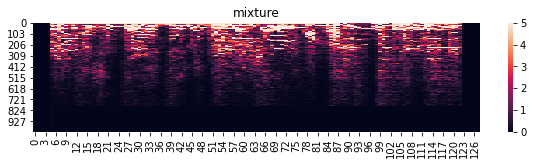

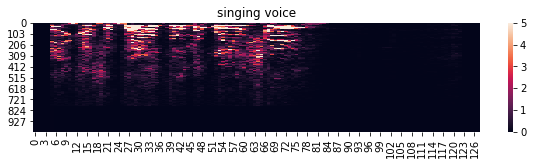

In [3]:
from ielab_audio.utils.fourier import multi_channeled_STFT

stft = multi_channeled_STFT(n_fft=2048, hop_length=1024)
M_complex = stft.to_spec_complex(mixture)

print('mixture shape:{}\nM_complex shape:{}'.format(mixture.shape, M_complex.shape))

M_mag = stft.to_mag(mixture)
T_mag = stft.to_mag(singing_voice)

import seaborn
import matplotlib.pyplot as plt
plt.figure(figsize=(10,2))
plt.title('mixture')
seaborn.heatmap(M_mag[:,:,0].detach().numpy(), vmax=5)
plt.show()
plt.figure(figsize=(10,2))
plt.title('singing voice')
seaborn.heatmap(T_mag[:,:,0].detach().numpy(), vmax=5)
plt.show()

##### 1.1.b. The complex-valued spectrogram estimation network
It is a  neural network that takes the spectrogram $\mathbf{M}$ of a mixture signal as input and estimates the target spectrogram $\hat{T} \in \mathbb{R} ^{\; \left(2c\right) \times T \times F}$, which is used for reconstructing the vocal signal later.

It can also be viewed as an **encoder-decoder network**. 

![](imgs/unet.png)

The TFC_TDF_Net uses [TFC_TDF](https://github.com/ws-choi/ISMIR2020_U_Nets_SVS/blob/master/paper_with_code/Paper%20with%20Code%20-%203.%20INTERMEDIATE%20BLOCKS.ipynb) blocks for intermediate blocks


```python
    def forward(self, x):

        x = self.first_conv(x)
        encoding_outputs = []

        for i in range(self.n):
            x = self.encoders[i](x)
            encoding_outputs.append(x)
            x = self.downsamplings[i](x)
        x = self.mid_block(x)

        for i in range(self.n):
            x = self.upsamplings[i](x)
            x = torch.cat((x, encoding_outputs[-i - 1]), 1)
            x = self.decoders[i](x)

        return self.last_conv(x)
```

![](../imgs/unet_svs.png)

<AxesSubplot:title={'center':'estmated singing voice (not trained)'}>

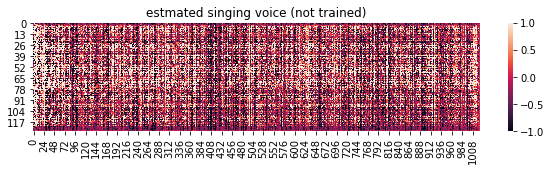

In [4]:
from ielab_audio.models.one2one_separation import TFC_TDF_NET_Framework

params = {'n_blocks':3, 'input_channels':4, 'internal_channels':4, 'n_internal_layers':3, 
          'first_conv_activation':'relu', 'last_activation':'identity',            
          't_down_layers':None, 'f_down_layers':None,
          'kernel_size_f':3, 'kernel_size_t':3,
          'bn_factor':16, 'min_bn_units':16, 'tfc_tdf_bias':False, 
          'tfc_tdf_activation':'relu',
          'tif_init_mode':None}

tfc_tdf_net = TFC_TDF_NET_Framework(
    target_name='vocals',
    n_fft=2048, hop_length=1024, num_frame=128,
    spec_type='complex', spec_est_mode='mapping',
    optimizer='rmsprop', lr=0.001, dev_mode=False,
    train_loss='ncs_44100', val_loss='nsdr_44100',
    layer_level_init_weight=True,
    unfreeze_stft_from=-1,
    **params
)

input_spec = tfc_tdf_net.to_spec(mixture.unsqueeze(0))
output_spec = tfc_tdf_net.spec2spec(input_spec).squeeze(0)

plt.figure(figsize=(10,2))
plt.title('estmated singing voice (not trained)')
seaborn.heatmap(output_spec.cpu()[0].detach().numpy(), vmin=-1, vmax=1)



##### 1.1.c. The signal reconstruction layer
It reshapes the estimated spectrogram $\hat{T}$ into the complex-valued spectrogram  $\hat{T}_{complex} \in \mathbb{C} ^{\; c \times T \times F}$, as shown in Figure \ref{fig:cac}. It then restores the estimated singing voice signal via inverse-STFT on $\hat{T}_{complex}$.

In [5]:
output_spec = output_spec.transpose(-1, -3)
output_spec = output_spec.view(list(output_spec.shape)[:-1] + [2, -1])
restored = stft.restore_complex(output_spec).cpu().detach().numpy()
ipd.Audio(restored.T, rate=44100)

#### 1.2. How to train TFC_TDF_Net?

Below is a conceptual code for training a TFC_TDF_Net, which is not the same as our implementation that abtracts functions for modularization.

```python

def training_step(self, batch, batch_idx):
    mixture_signal, target_signal, _ = batch

    # target spectrogram estimation
    M_complex = model.to_spec(mixture_signal)
    T_complex_hat = model.spec2spec(M_complex)
    
    # ground-truth target spectrogram
    T_complex = model.to_spec(target_signal)

    loss = self.criterion(T_complex_hat, T_complex)
    
    # for pytorch-lightning
    result = pl.TrainResult(loss)
    result.log('train_loss', loss, prog_bar=False, logger=True, on_step=False, on_epoch=True,
               reduce_fx=torch.mean)
    return result
        
```

In [6]:
import  pytorch_lightning as pl
from ielab_audio.data.musdb_wrapper import DataProvider
data_provider = DataProvider(musdb_root='../data/musdb18_wav', musdb_is_wav=True, filed_mode=True,
                             target_names=['vocals'], batch_size=64, pin_memory=True, num_workers=8,
                             dev_mode=False, one_hot_mode=False)
trainer = pl.Trainer(logger=False, checkpoint_callback=False, early_stop_callback=False, gpus=1, precision=16,
                    max_epochs=10, val_percent_check = 0)
train_dataloader = data_provider.get_train_dataloader(n_fft=2048, hop_length=1024, num_frame=128)

pl.seed_everything(2020)
tfc_tdf_net.init_weights()
trainer.fit(tfc_tdf_net, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
C:\Users\Woosung Choi\miniconda3\envs\cunet_pytorch\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name      | Type                 | Params
---------------------------------------------------
0 | stft      | multi_channeled_STFT | 2 K   
1 | spec2spec | TFC_TDF_NET          | 298 K 


Saving latest checkpoint..


1

#### 1.3. After few epochs

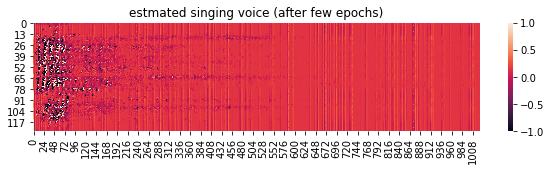

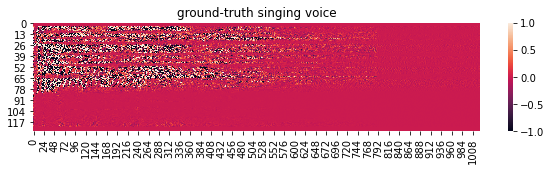

In [7]:
tfc_tdf_net.eval()
input_spec = tfc_tdf_net.to_spec(mixture.unsqueeze(0))
output_spec = tfc_tdf_net.spec2spec(input_spec).squeeze(0)

plt.figure(figsize=(10,2))
plt.title('estmated singing voice (after few epochs)')
seaborn.heatmap(output_spec.cpu()[0].detach().numpy(), vmin=-1, vmax=1)

plt.figure(figsize=(10,2))
plt.title('ground-truth singing voice')
target_spec = tfc_tdf_net.to_spec(singing_voice)
seaborn.heatmap(target_spec.cpu()[0].detach().numpy(), vmin=-1, vmax=1)

output_spec = output_spec.transpose(-1, -3)
output_spec = output_spec.view(list(output_spec.shape)[:-1] + [2, -1])
restored = stft.restore_complex(output_spec).cpu().detach().numpy()
ipd.Audio(restored.T, rate=44100)

In [8]:
print(tfc_tdf_net)

TFC_TDF_NET_Framework(
  (stft): multi_channeled_STFT(
    (stft): STFT()
  )
  (spec2spec): TFC_TDF_NET(
    (first_conv): Sequential(
      (0): Conv2d(4, 4, kernel_size=(1, 2), stride=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (encoders): ModuleList(
      (0): TFC_TIF(
        (tfc): TFC(
          (H): ModuleList(
            (0): Sequential(
              (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (1): Sequential(
              (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (2): Sequential(
              (0): Conv2d(12, 4, kernel_size=(3, 3), stride=(1, 1),